In [1]:
from stable_baselines3 import HerReplayBuffer, PPO, SAC
from stable_baselines3.her.goal_selection_strategy import GoalSelectionStrategy
from stable_baselines3.common.evaluation import evaluate_policy
import gymnasium as gym
import numpy as np
import time
import matplotlib.pyplot as plt
from gymnasium.envs.registration import register

register(
    # unique identifier for the env `name-version`
    id="RobotEnv-v0",
    # path to the class for creating the env
    # Note: entry_point also accept a class as input (and not only a string)
    entry_point="Robot_env:RobotEnv",
)
env = gym.make("RobotEnv-v0")
algorithm_name = input("algorithm name: ")
EpiLen = input("Episode Length: ")
# model_folder_name = "./model/"+"model_"+algorithm_name+"_"+EpiLen+"EpiLen"
model_path = "./models/"+algorithm_name+"/model_"+algorithm_name+"_"+EpiLen+"EpiLen"
if algorithm_name=="PPO":
    model = PPO.load(model_path, env=env)
elif algorithm_name=="SAC":
    model = SAC.load(model_path, env=env)

x_min,x_max,y_min,y_max = [],[],[],[]
x_state,y_state,theta_state,rew = [],[],[],[]
for _ in range(1):
    obs, info = env.reset()
    for i in range(int(EpiLen)):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        x_state.append(obs[0])
        y_state.append(obs[1])
        theta_state.append(obs[2])
        rew.append(reward)
        x_min.append(info['x_min'])
        x_max.append(info['x_max'])
        y_min.append(info['y_min'])
        y_max.append(info['y_max'])
        
        if terminated or truncated:
            obs, info = env.reset()
    env.render()
env.close()


2023-10-10 14:54:28.858987: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-10 14:54:29.059760: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-10 14:54:29.059781: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-10 14:54:29.060373: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-10 14:54:29.144371: I tensorflow/core/platform/cpu_feature_g

algorithm name:  SAC
Episode Length:  20


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Text(0, 0.5, 'y - state')

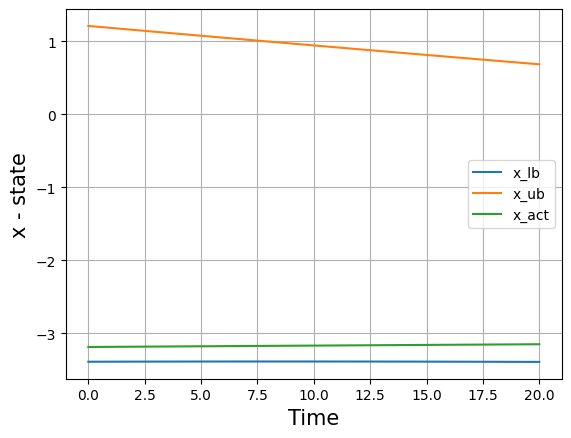

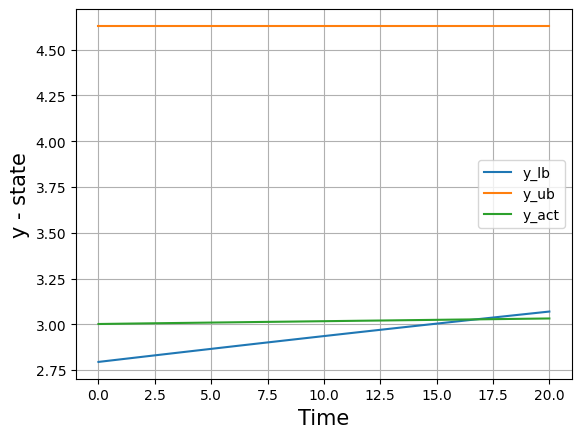

In [2]:
#plots of state x,y

time = np.linspace(0,20,int(EpiLen))
plt.plot(time,x_min,time,x_max,time,x_state)
plt.xlabel("Time",fontsize=15)
plt.ylabel('x - state',fontsize=15)
plt.legend(['x_lb','x_ub','x_act'])
plt.grid()
plt.figure()
plt.plot(time,y_min,time,y_max,time,y_state)
plt.legend(['y_lb','y_ub','y_act'])
plt.grid()
plt.xlabel("Time",fontsize=15)
plt.ylabel('y - state',fontsize=15)

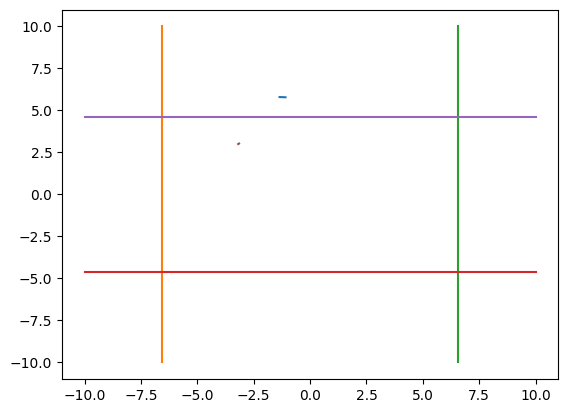

In [3]:
import math
time = np.linspace(-10,10,int(EpiLen))
time_int = 0.01
xd=[[-1.5+5.8*math.cos(0.24*time_int*t+1.5), 5.8*math.sin(0.24*t*time_int+1.5)] for t in range(int(EpiLen))]
state_d = np.array(xd)
time = np.linspace(-10,10,int(EpiLen))
x_lb_hard = [-6.58 for i in range(int(EpiLen))]
x_ub_hard = [6.58 for i in range(int(EpiLen))]
lb_hard_y = [-4.63 for i in range(int(EpiLen))]
ub_hard_y = [4.63 for i in range(int(EpiLen))]
plt.plot(state_d[:,0],state_d[:,1],x_lb_hard,time,x_ub_hard,time,time,lb_hard_y,time,ub_hard_y,x_state,y_state)

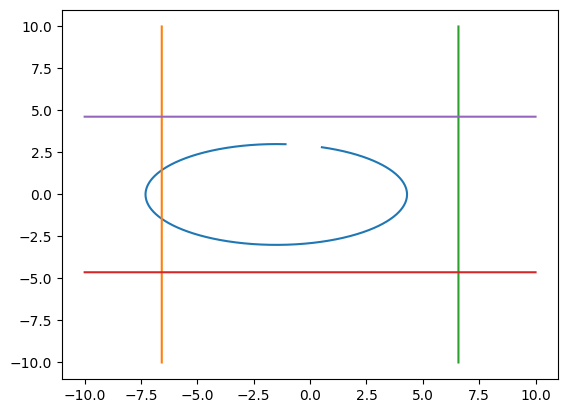

In [8]:
import math
EpiLen = 2500
time = np.linspace(-10,10,EpiLen)
time_int = 0.01
xd=[[-1.5+5.8*math.cos(0.24*time_int*t+1.5), 3*math.sin(0.24*t*time_int+1.5)] for t in range(EpiLen)]
state_d = np.array(xd)
time = np.linspace(-10,10,EpiLen)
x_lb_hard = [-6.58 for i in range(EpiLen)]
x_ub_hard = [6.58 for i in range(EpiLen)]
lb_hard_y = [-4.63 for i in range(EpiLen)]
ub_hard_y = [4.63 for i in range(EpiLen)]
plt.plot(state_d[:,0],state_d[:,1],x_lb_hard,time,x_ub_hard,time,time,lb_hard_y,time,ub_hard_y)

In [9]:
state_d[0]

array([-1.08972423,  2.99248496])